# Importing Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sc
import scipy.io as io
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, pmap, random, lax, value_and_grad, tree_map, devices
import jax.example_libraries.optimizers as jeo

from tqdm import trange

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

In [3]:
num_mach = 1

# Prior Functions

In [4]:
@jit
def AlpEnvelope(Xarr, TRise, TauDiff, Lag):
  TRise = TRise ** 2.0
  TDecay = TRise + TauDiff ** 2 + 1e-8
  TMax = (jnp.log(TRise / TDecay) * TDecay * TRise) / (TRise - TDecay)
  Max =  jnp.exp(- TMax / TDecay) - jnp.exp(- TMax / TRise)
  Delayed = Xarr - Lag
  NewTime = jnp.where(Delayed < 0.0, 1000, Delayed)
  return (jnp.exp(- NewTime / TDecay) - jnp.exp(- NewTime / TRise)) / Max

In [5]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

# Test Data

In [6]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

In [7]:
# Time resolution
time_bin = 0.005

### Input Spike Train

In [8]:
subkeyx = subkeys[-1]

# Time horizon for input data
x_maxt = 12.0
batch_size = 1
num_filt = num_mach * batch_size

# Maximum index of input data
n = np.floor(x_maxt/time_bin).astype(np.int64)

ytime = np.linspace(0.0, x_maxt, n + 1).reshape(n + 1, 1)

spikedat1 = random.bernoulli(subkeyx, 0.1, (num_filt * (n + 1),)).astype(np.float64).reshape(num_filt, n + 1, 1)
spikedat2 = random.bernoulli(subkeys[-2], 0.1, (num_filt * (n + 1),)).astype(np.float64).reshape(num_filt, n + 1, 1)
spikedat3 = random.bernoulli(subkeys[-3], 0.1, (num_filt * (n + 1),)).astype(np.float64).reshape(num_filt, n + 1, 1)

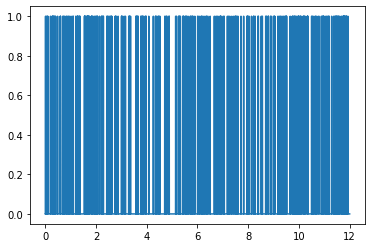

In [9]:
plt.plot(ytime, spikedat2.flatten())

### True Filter

In [10]:
subkeyf = subkeys[-2]

# Filter horizon
f_maxt = 1.0

# Maximum index of filter data
k = np.floor(f_maxt/time_bin).astype(np.int64)
ftime = np.linspace(0.0, f_maxt, k + 1).reshape(k + 1, 1)

# Damped frequency
w_d = 18.0

# Sqrt True rise rate
tau_rise = np.sqrt(0.09)

# Sqrt True diff
tau_diff = np.sqrt(0.001)

# True lag
lag = 0.05

env_true = AlpEnvelope(ftime, tau_rise, tau_diff, lag)

# Envelope peak
sqtr = tau_rise ** 2
sqtd = sqtr + tau_diff ** 2
tmax = (np.log(sqtr / sqtd) * sqtd * sqtr) / (sqtr - sqtd)

ftrue = (np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))) * env_true).reshape(k + 1, 1)

num_filt = 1

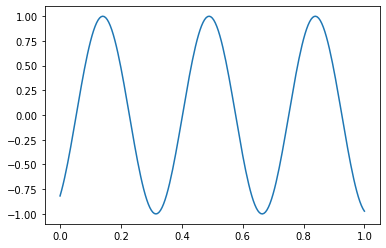

In [11]:
plt.plot(ftime, np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))))

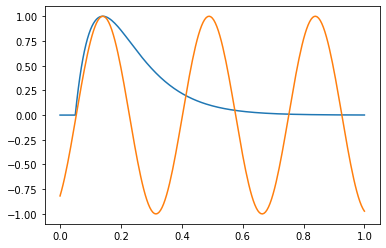

In [12]:
plt.plot(ftime, env_true)
plt.plot(ftime, np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))))

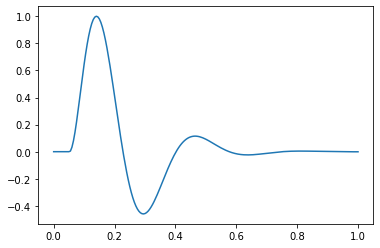

In [13]:
plt.plot(ftime, ftrue)

### True Noise

In [14]:
subkeyn = subkeys[-3]

# True noise variance
sign_true = 0.05

# Noise vector
noise_vec = sign_true * random.normal(subkeyn, (n + 1, 1))

### Output

In [15]:
# Padding and applying the FFT
spikepad1 = np.hstack((spikedat1, np.zeros((num_filt, k, 1))))
spikepad2 = np.hstack((spikedat2, np.zeros((num_filt, k, 1))))
spikepad3 = np.hstack((spikedat3, np.zeros((num_filt, k, 1))))

fpad = np.vstack((ftrue.reshape((k + 1, 1)), np.zeros((n, 1))))

spikefft1 = np.fft.rfft(spikepad1, axis = 1)
spikefft2 = np.fft.rfft(spikepad2, axis = 1)
spikefft3 = np.fft.rfft(spikepad3, axis = 1)
spikef = [spikefft1, spikefft2, spikefft3]

fftlen1 = np.shape(spikefft1)[1]
fftlen2 = np.shape(spikefft2)[1]
fftlen3 = np.shape(spikefft3)[1]
fftlen = [fftlen1, fftlen2, fftlen3]

spikefft = [spikef[j].reshape(num_mach, batch_size, fftlen[j], 1) for j in range(3)]
spikefft = [[spikefft[j][i] for j in range(3)] for i in range(num_mach)]

f_fft = np.fft.rfft(fpad, axis = 0)

fftmul = [[spikefft[j][i] * f_fft for i in range (3)] for j in range(num_mach)]

fftsum = [[fftmul[j][i] for j in range(num_mach)] for i in range(3)]
fftsummach = [np.sum(fftsum[i], axis = 0) for i in range(3)]

ynonoise = [np.fft.irfft(np.sum(fftsummach[i], axis = 0), k + n + 1, axis = -2)[: n + 1] for i in range(3)]
yvel = [(ynonoise[i] + noise_vec).reshape(n + 1, 1) for i in range(3)]

spikefft = jnp.asarray(spikefft)
yvel = jnp.asarray(yvel)

In [16]:
# Showing equals the raw convolution
yffttest = np.convolve(spikedat1.flatten(), ftrue.flatten())[:n + 1] + noise_vec.flatten()

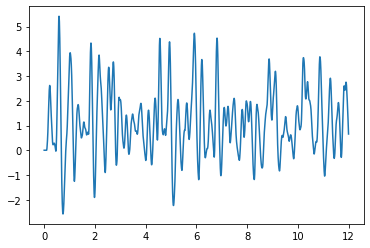

In [17]:
plt.plot(ytime, ynonoise[0].flatten())

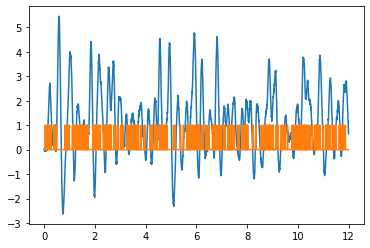

In [18]:
plt.plot(ytime, yvel[0].flatten())
plt.plot(ytime, spikedat1.flatten())

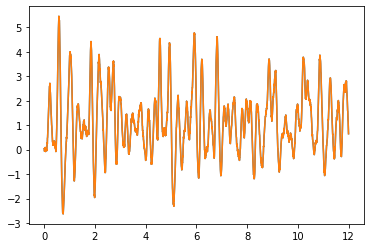

In [19]:
plt.plot(ytime, yffttest.flatten())
plt.plot(ytime, yvel[0].flatten())

In [20]:
print(spikefft[0][0].shape)
print(ytime.shape)
print(yvel[0].shape)

(1, 1301, 1)
(2401, 1)
(2401, 1)


# ELBO 

In [21]:
Diag = vmap(jnp.diag)

In [22]:
@jit
def Solver(Kmm, Diff):
  return jsc.linalg.solve(Kmm, Diff, sym_pos=True, check_finite=True)

In [23]:
V_Solver = vmap(Solver, in_axes = [None, 0])

In [24]:
@jit
def Likelihoods(Predictions, Velocity, Sigma_n, N):
  return - 0.5 * ((N + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                    jnp.sum((Velocity - Predictions)**2, axis = -2)/(Sigma_n ** 2))

In [25]:
Likely = vmap(Likelihoods, in_axes=(0, 0, None, 0,))

In [26]:
@partial(jit, static_argnums = range(10, 19))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Number_F, Num_Base, M, Num_Filt, Batch_Size, K, N0, N1, N2,
              Indices, Spike_Fft, Velocity, F_Time, Subkeys):

  # Creating lag and z-vector         
  Lag = Lag ** 2.0
  
  Z_Vector = (0.5 * jnp.sin( jnp.pi * (Z_Fractions - 0.5)) + 0.5) * (F_Time[-1, 0] - Lag) + Lag

  # Creating the L-matrix
  D = Diag(jnp.exp(L_Diag))

  L_Matrix = D.at[:, Indices[0], Indices[1]].set(L_ODiag)

  # KL term
  KL = 0.5 * (- jnp.sum(jnp.log(jnp.diagonal(L_Matrix, axis1 = 1, axis2 = 2) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - Batch_Size * M)

  # Expectation term
  Thetas = random.normal(Subkeys[0], (Number_F, Batch_Size, 1, Num_Base)) * (1.0 / Ell)

  Taus = random.uniform(Subkeys[1], (Number_F, Batch_Size, 1, Num_Base)) * 2.0 * jnp.pi

  Omegas = random.normal(Subkeys[2], (Number_F, Batch_Size, Num_Base, 1))

  Constant = (Sigma_f * jnp.sqrt(2.0 / Num_Base))

  ZT = Z_Vector.transpose(0, 2, 1)
 
  Phi1 = Constant * jnp.cos(F_Time * Thetas + Taus)
  Phi2 = Constant * jnp.cos(Z_Vector * Thetas + Taus)

  Kmm = Squared_exp(Z_Vector, ZT, Sigma_f, Ell)
  Knm = Squared_exp(F_Time, ZT, Sigma_f, Ell)

  C = jnp.linalg.cholesky(Kmm + jnp.eye(M) * 1e-6)

  V_u = C @ L_Matrix @ L_Matrix.transpose(0, 2, 1) @ C.transpose(0, 2, 1)

  Mu_u = C @ V_Vector

  V_uChol = jnp.linalg.cholesky(V_u + 1e-6 * jnp.eye(M))

  U_Samples = Mu_u + V_uChol @ random.normal(Subkeys[3], (Number_F, Batch_Size, M, 1))

  Vu = V_Solver(Kmm + 1e-6 * jnp.eye(M), U_Samples - Phi2 @ Omegas)

  F_Samples = (Phi1 @ Omegas + Knm @ Vu) * AlpEnvelope(F_Time, TRise, TauDiff, Lag)

  F_Fft0 = jnp.fft.rfft(F_Samples, n = N0 + K + 1, axis = -2)
  F_Fft1 = jnp.fft.rfft(F_Samples, n = N1 + K + 1, axis = -2)
  F_Fft2 = jnp.fft.rfft(F_Samples, n = N2 + K + 1, axis = -2)

  Filter_Out0 = jnp.fft.irfft(F_Fft0 * Spike_Fft[0], N0 + K + 1, axis = -2)[:, :, : N0 + 1].sum(axis = 1)
  Filter_Out1 = jnp.fft.irfft(F_Fft1 * Spike_Fft[1], N1 + K + 1, axis = -2)[:, :, : N1 + 1].sum(axis = 1)
  Filter_Out2 = jnp.fft.irfft(F_Fft2 * Spike_Fft[2], N2 + K + 1, axis = -2)[:, :, : N2 + 1].sum(axis = 1)

  Filter0 = lax.psum(Filter_Out0, axis_name="machs")
  Filter1 = lax.psum(Filter_Out1, axis_name="machs")
  Filter2 = lax.psum(Filter_Out2, axis_name="machs")

  Filter = jnp.asarray([Filter0, Filter1, Filter2])
  N = jnp.asarray([N0, N1, N2])

  Likelihood0 = Likely(Filter, Velocity, Sigma_n, N).sum(axis=0)

  KL = lax.psum(KL, axis_name="machs")
  Exp = jnp.mean(Likelihood0)
                  
  return (KL-Exp)/(Num_Filt * jnp.sum(N) + 1)

In [27]:
PNeg = pmap(Neg_ELBO, axis_name = "machs", in_axes=(0, 0, None, 0, 0, 0, 0, 0, 0, 0, None, None, None, None, None, None, None, None, None, None, 0, None, None, 0,),
            static_broadcasted_argnums = range(10, 19))

In [28]:
test_number_f = 15
test_num_base = 100
test_m = int(3)

test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 1 + 4 * num_mach)
test_subkeys = np.asarray(test_subkeys).astype(np.uint32).reshape(num_mach, 4, 2)

test_sigma_f = 2.0 * np.ones((num_mach, batch_size, 1, 1))# np.arange(num_mach * batch_size).reshape(num_mach, batch_size, 1, 1)
test_ell_f = 0.7 * np.ones((num_mach, batch_size, 1, 1))
test_sigma_n = 0.01
test_z_final = jnp.tile(jnp.linspace(0.0, 1.0, test_m).reshape((test_m, 1)), (num_mach, batch_size, 1, 1))
test_z_m = (jnp.arcsin(2.0 * (test_z_final - 0.5)) / jnp.pi) + 0.5
test_v_m = 5.0 * np.ones((num_mach, batch_size, test_m, 1))
test_l_diag = np.ones((num_mach, batch_size, test_m))
test_l_odiag = np.tile(np.tril(np.ones((test_m, test_m)), -1)[np.tril_indices(test_m, -1)], (num_mach, batch_size, 1))
test_trise = 0.02 * np.ones((num_mach, batch_size, 1, 1))
test_tdiff = 0.03 * np.ones((num_mach, batch_size, 1, 1))
test_lag = 0.01 * np.ones((num_mach, batch_size, 1, 1))
test_indices = np.tril_indices(test_m, -1)

In [30]:
nelbo = PNeg(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_diag,
                test_l_odiag, test_trise, test_tdiff, test_lag, test_number_f, test_num_base,
                test_m, num_filt, batch_size, k, n, n, n, test_indices, spikefft, yvel, 
                ftime, test_subkeys)

In [31]:
print(nelbo)

[14427.5483738]


In [32]:
Grad_Bound = value_and_grad(Neg_ELBO, argnums = range(10))

# Training the Model

In [33]:
@jit
def MCalc(Grad, M, B1 = 0.9):
  return (1 - B1) * Grad + B1 * M

In [34]:
@jit
def MBias(M, Step, B1 = 0.9):
  return M / (1 - B1 ** (Step + 1))

In [35]:
@jit
def VCalc(Grad, V, B2 = 0.99):
  return (1 - B2) * jnp.square(Grad) + B2 * V

In [36]:
@jit
def VBias(V, Step, B2 = 0.99):
  return V / (1 - B2 ** (Step + 1))

In [37]:
@jit
def CFinState(X, Mhat, Vhat, Step_Size = 1e-2, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [38]:
@jit
def MFinState(X, Mhat, Vhat, Step_Size = 1e-3, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [39]:
@jit
def FFinState(X, Mhat, Vhat, Step_Size = 1e-4, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [40]:
@jit
def CAdam(Step, X, Grad, M, V):

  M = tree_map(MCalc, Grad, M) # First  moment estimate.
  V = tree_map(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_map(CFinState, X, Mhat, Vhat)

  return X, M, V

In [41]:
@jit
def MAdam(Step, X, Grad, M, V):

  M = tree_map(MCalc, Grad, M) # First  moment estimate.
  V = tree_map(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_map(MFinState, X, Mhat, Vhat)

  return X, M, V

In [42]:
@jit
def FAdam(Step, X, Grad, M, V):

  M = tree_map(MCalc, Grad, M) # First  moment estimate.
  V = tree_map(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_map(FFinState, X, Mhat, Vhat)

  return X, M, V

In [43]:
@partial(pmap, axis_name = "machs", in_axes=(None, 0, 0, None, 0, 0, 0, 0, 0, 0, 0, None, 
                                    None, None, None, None, None, None, None, None, None, 
                                    0, None, None, 0, 0, 0, 0,),
                static_broadcasted_argnums = range(11, 20))

def _CUpdate(Iter, Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Num_Coarse_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N0, N1, N2,
              Indices, Spike_Fft, Velocity, F_Time, Subkeys, Key, Mad, Vad):
  
  Value, Grads = Grad_Bound(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Num_Coarse_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N0, N1, N2,
                  Indices, Spike_Fft, Velocity, F_Time, Subkeys)
  
  X, Mad, Vad = CAdam(Iter, (Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag), Grads, Mad, Vad)

  Key, *Subkeys = random.split(Key, 5)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(4, 2)

  return *X, Subkeys, Key, Mad, Vad, Value

In [44]:
@partial(pmap, axis_name = "machs", in_axes=(None, 0, 0, None, 0, 0, 0, 0, 0, 0, 0, None, 
                                    None, None, None, None, None, None, None, None, None, 
                                    0, None, None, 0, 0, 0, 0,),
                static_broadcasted_argnums = range(11, 20))

def _MUpdate(Iter, Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Num_Mid_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N0, N1, N2,
              Indices, Spike_Fft, Velocity, F_Time, Subkeys, Key, Mad, Vad):
  
  Value, Grads = Grad_Bound(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Num_Mid_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N0, N1, N2,
                  Indices, Spike_Fft, Velocity, F_Time, Subkeys)
  
  X, Mad, Vad = MAdam(Iter, (Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag), Grads, Mad, Vad)

  Key, *Subkeys = random.split(Key, 5)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(4, 2)

  return *X, Subkeys, Key, Mad, Vad, Value

In [45]:
@partial(pmap, axis_name = "machs", in_axes=(None, 0, 0, None, 0, 0, 0, 0, 0, 0, 0, None, 
                                    None, None, None, None, None, None, None, None, None, 
                                    0, None, None, 0, 0, 0, 0,),
                static_broadcasted_argnums = range(11, 20))

def _FUpdate(Iter, Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Num_Fine_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N0, N1, N2,
              Indices, Spike_Fft, Velocity, F_Time, Subkeys, Key, Mad, Vad):
  
  Value, Grads = Grad_Bound(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Num_Fine_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N0, N1, N2,
                  Indices, Spike_Fft, Velocity, F_Time, Subkeys)
  
  X, Mad, Vad = FAdam(Iter, (Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag), Grads, Mad, Vad)

  Key, *Subkeys = random.split(Key, 5)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(4, 2)

  return *X, Subkeys, Key, Mad, Vad, Value

In [46]:
@partial(pmap, in_axes = (0, 0, None, 0, 0, 0, 0, 0, 0, 0,))
def Init_Adam(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag):
  X = (Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag)

  Mad = tree_map(jnp.zeros_like, X)

  return Mad, Mad
  

In [47]:
key = random.PRNGKey(4)

# Initialising the parameters

# Generative parameters
isigma_f = 1.0 * jnp.ones((num_mach, batch_size, 1, 1))
iell = 0.002 * jnp.ones ((num_mach, batch_size, 1, 1))
isigma_n = 0.000000005
itrise = np.sqrt(0.05) * jnp.ones((num_mach, batch_size, 1, 1))
itaudiff = np.sqrt(0.01) * jnp.ones((num_mach, batch_size, 1, 1))
ilag = np.sqrt(0.01) * jnp.ones((num_mach, batch_size, 1, 1))

sigma_f = isigma_f
ell = iell
sigma_n = isigma_n
trise = itrise
taudiff = itaudiff
lag = ilag

# Variational parameters
num_f = 15
num_b = 100
num_ind = 20
iz_final = jnp.tile(jnp.linspace(0.0, 1.0, num_ind).reshape((num_ind, 1)), (num_mach, batch_size, 1, 1))
iz_fracs = (jnp.arcsin(2.0 * (iz_final - 0.5)) / jnp.pi) + 0.5
key, *subkeys = random.split(key, 4)
iv_vector = 0.01 * random.normal(subkeys[-3], (num_mach, batch_size, num_ind, 1))
il_diag = 0.01 * random.normal(subkeys[-2], (num_mach, batch_size, num_ind))
il_odiag = 0.1 * random.normal(subkeys[-1], (num_mach, batch_size, int((num_ind ** 2 - num_ind) / 2)))
indices = jnp.asarray(jnp.tril_indices(num_ind, -1))

z_fracs = iz_fracs
v_vector = iv_vector
l_diag = il_diag
l_odiag = il_odiag

# Random number generator
iopt_key = np.asarray([random.PRNGKey(i) for i in range(num_mach)]).astype(np.uint32)
itest = vmap(random.split, in_axes=(0, None))(iopt_key, 1 + 4 * num_mach)
iopt_key = np.asarray([itest[i][0] for i in range(num_mach)]).astype(np.uint32)
iopt_subkey = np.asarray([itest[i][1:] for i in range(num_mach)]).astype(np.uint32)

opt_key = iopt_key
opt_subkey = iopt_subkey
print(opt_subkey.shape)

(1, 4, 2)


In [48]:
mad, vad = Init_Adam(isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag,
              il_odiag, itrise, itaudiff, ilag)

In [49]:
step = 0
elbo_history = np.zeros(20000)

In [50]:
step = 0
for i in trange(1500):  
  sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag, l_odiag, trise, taudiff, lag, st, kt, mad, vad, value = _CUpdate(i, sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag, l_odiag, trise, taudiff, lag, num_f, num_b, num_ind, num_filt, batch_size, k, n, n, n, indices, spikefft, yvel, ftime, opt_subkey, opt_key, mad, vad)
  sigma_n = sigma_n[0]
  elbo_history[step] = -value[0]
  step += 1

100%|██████████| 1500/1500 [00:22<00:00, 68.06it/s] 


In [51]:
for i in trange(16500):
    sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag, l_odiag, trise, taudiff, lag, st, kt, mad, vad, value = _MUpdate(i, sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag,
                  l_odiag, trise, taudiff, lag, num_f, num_b,
                  num_ind, num_filt, batch_size, k, n, n, n, indices, spikefft, yvel, 
                  ftime, opt_subkey, opt_key, mad, vad)
    sigma_n = sigma_n[0]
    elbo_history[step] = -value[0]
    step += 1

100%|██████████| 16500/16500 [02:36<00:00, 105.22it/s]


In [52]:
for i in trange(2000):
    sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag, l_odiag, trise, taudiff, lag, st, kt, mad, vad, value = _FUpdate(i, sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag,
                  l_odiag, trise, taudiff, lag, num_f, num_b,
                  num_ind, num_filt, batch_size, k, n, n, n, indices, spikefft, yvel, 
                  ftime, opt_subkey, opt_key, mad, vad)
    sigma_n = sigma_n[0]
    elbo_history[step] = -value[0]
    step += 1

100%|██████████| 2000/2000 [00:24<00:00, 80.66it/s] 


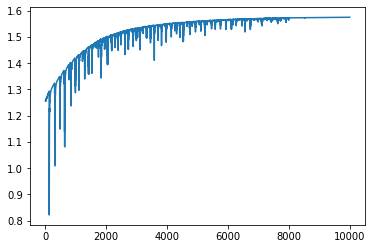

In [53]:
plt.plot(elbo_history[10000:])

In [54]:
print(PNeg(isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag,
                il_odiag, itrise, itaudiff, ilag, num_f, num_b,
                num_ind, num_filt, batch_size, k, n, n, n, indices, spikefft, yvel, 
                ftime, iopt_subkey))

[1.15911705e+17]


In [55]:
print(PNeg(sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag,
                l_odiag, trise, taudiff, lag, num_f, num_b,
                num_ind, num_filt, batch_size, k, n, n, n, indices, spikefft, yvel, 
                ftime, iopt_subkey))

[-1.57518345]


In [56]:
fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag, ftrise, ftaudiff, flag = sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag, l_odiag, trise, taudiff, lag

In [57]:
@jit
def Set(Matrix, Indices, NewVals):
  return Matrix.at[:, Indices[0], Indices[1]].set(NewVals)

In [58]:
PDiag = pmap(Diag)

In [59]:
PSet = pmap(Set, in_axes=(0, None, 0,))

In [60]:
ilag = ilag ** 2

iz_vector = (0.5 * np.sin( np.pi * (iz_fracs - 0.5)) + 0.5) * (ftime[-1, 0] - ilag) + ilag

idz = PDiag(np.exp(il_diag))
print(il_diag.shape)
print(idz.shape)
il_matrix = PSet(idz, indices, il_odiag)


flag = flag ** 2

fz_vector = (0.5 * np.sin( np.pi * (fz_fracs - 0.5)) + 0.5) * (ftime[-1] - flag) + flag

fd = PDiag(np.exp(fl_diag))
fl_matrix = PSet(fd, indices, fl_odiag)
print(fd.shape)
print(fl_matrix.shape)

(1, 1, 20)
(1, 1, 20, 20)
(1, 1, 20, 20)
(1, 1, 20, 20)


In [61]:
isigma_ff = isigma_f.reshape(num_filt, 1)
iellf = iell.reshape(num_filt, 1)
iz_vectorf = iz_vector.reshape(num_filt, num_ind, 1)
iv_vectorf = iv_vector.reshape(num_filt, num_ind, 1)
il_matrixf = il_matrix.reshape(num_filt, num_ind, num_ind)
itrisef = itrise.reshape(num_filt, 1)
itaudifff = itaudiff.reshape(num_filt, 1)
ilagf = ilag.reshape(num_filt, 1)

fsigma_ff = fsigma_f.reshape(num_filt, 1)
fellf = fell.reshape(num_filt, 1)
fz_vectorf = fz_vector.reshape(num_filt, num_ind, 1)
fv_vectorf = fv_vector.reshape(num_filt, num_ind, 1)
fl_matrixf = fl_matrix.reshape(num_filt, num_ind, num_ind)
ftrisef = ftrise.reshape(num_filt, 1)
ftaudifff = ftaudiff.reshape(num_filt, 1)
flagf = flag.reshape(num_filt, 1)

In [62]:
print(len(spikefft))

1


In [63]:
spikeffta = [np.asarray([spikefft[i][j] for i in range(num_mach)]) for j in range(3)]

In [64]:
spikefftf = [spikeffta[i].reshape(num_filt, fftlen[i], 1) for i in range(3)]

In [65]:
print(len(spikefftf))
print(spikefftf[0].shape)

3
(1, 1301, 1)


In [66]:
print(fsigma_ff)

[[0.45803982]]


In [67]:
print(fellf)

[[-0.0718905]]


In [68]:
print(fsigma_n)

0.04960188004587175


In [69]:
print(ftrisef)

[[0.21234333]]


In [70]:
print(ftaudifff)

[[0.26558662]]


In [71]:
print(flagf)

[[0.05638363]]


## Variational Predictions

In [72]:
fpred_points = ftime.copy()

In [73]:
scisigmaf = isigma_ff[:, None]
sciellf = iellf[:, None]
scitrisef = itrisef[:, None]
scitaudifff = itaudifff[:, None]
scilagf = ilagf[:, None]

ikmm = Squared_exp(iz_vectorf, iz_vectorf.transpose(0, 2, 1), scisigmaf, sciellf)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Squared_exp(iz_vectorf, fpred_points.T, scisigmaf, sciellf)
ibzast = np.zeros((num_filt, num_ind, k + 1))
for i in range(num_filt):
  ibzast[i] = sc.linalg.solve_triangular(icpred[i], ikzast[i], lower = True)
ibzastT = ibzast.transpose(0, 2, 1)
ipredenv = AlpEnvelope(fpred_points, scitrisef, scitaudifff, scilagf)
ipredenvT = ipredenv.transpose(0, 2, 1)
imeanpred = ipredenv * (ibzastT @ iv_vectorf)
ikastast = Squared_exp(fpred_points, fpred_points.T, scisigmaf, sciellf)
icovpred = ipredenv * (ikastast + ibzastT @ (il_matrixf @ il_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ ibzast) * ipredenvT

In [74]:
scfsigmaf = fsigma_ff[:, None]
scfellf = fellf[:, None]
scftrisef = ftrisef[:, None]
scftaudifff = ftaudifff[:, None]
scflagf = flagf[:, None]

fkmm = Squared_exp(fz_vectorf, fz_vectorf.transpose(0, 2, 1), scfsigmaf, scfellf)
fcpred = np.linalg.cholesky(fkmm + 1e-6 * np.eye(num_ind))
fkzast = Squared_exp(fz_vectorf, fpred_points.T, scfsigmaf, scfellf)
fbzast = np.zeros((num_filt, num_ind, k + 1))
for i in range(num_filt):
  fbzast[i] = sc.linalg.solve_triangular(fcpred[i], fkzast[i], lower = True)
fbzastT = fbzast.transpose(0, 2, 1)
fpredenv = AlpEnvelope(fpred_points, scftrisef, scftaudifff, scflagf)
fpredenvT = fpredenv.transpose(0, 2, 1)
fmeanpred = fpredenv * (fbzastT @ fv_vectorf)

fkastast = Squared_exp(fpred_points, fpred_points.T, scfsigmaf, scfellf)
fcovpred = fpredenv * (fkastast + fbzastT @ (fl_matrixf @ fl_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ fbzast) * fpredenvT

In [75]:
print(imeanpred.shape)

(1, 201, 1)


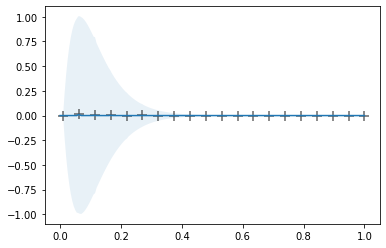

In [76]:
ipredindenv = AlpEnvelope(iz_vectorf, scitrisef, scitaudifff, scilagf)
index = 2
plt.plot(fpred_points, imeanpred[index])
is2 = np.sqrt(np.diag(icovpred[index]))
ifill = (imeanpred[index].flatten() - is2, imeanpred[index].flatten() + is2)
plt.fill_between(fpred_points.flatten(), *ifill, alpha = 0.1)
plt.scatter(iz_vectorf[index], (ipredindenv * (icpred @ iv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

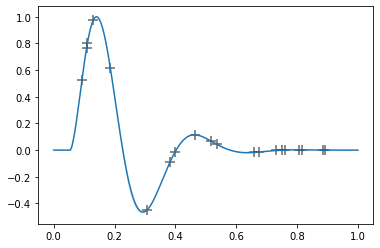

In [77]:
predindenv = AlpEnvelope(fz_vectorf, scftrisef, scftaudifff, scflagf)

plt.plot(fpred_points, fmeanpred[index])
s2 = np.sqrt(np.diag(fcovpred[index]))
fill = (fmeanpred[index].flatten() - s2, fmeanpred[index].flatten() + s2)
plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
plt.scatter(fz_vectorf[index], (predindenv * (fcpred @ fv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

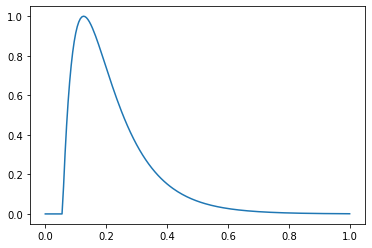

In [78]:
envelopes = AlpEnvelope(ftime, scftrisef, scftaudifff, scflagf)
for i in envelopes:
  plt.plot(ftime, i)

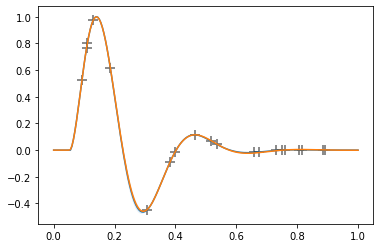

In [79]:
for index in range(num_filt):
  plt.plot(fpred_points, fmeanpred[index])
  s2 = np.sqrt(np.diag(fcovpred[index]))
  fill = (fmeanpred[index].flatten() - s2, fmeanpred[index].flatten() + s2)
  plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
  plt.scatter(fz_vectorf[index], (predindenv * (fcpred @ fv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
  #plt.xlim([ftime[0], ftime[-1]])

plt.plot(ftime, ftrue)

In [80]:
def OUTconvolve(Filters, K, N, Spike_FFT):
  Pad = np.hstack((Filters, np.zeros((num_filt, N, 1))))
  Pred_fft = np.fft.rfft(Pad, axis = -2)
  Pred_sum = np.sum(Pred_fft * Spike_FFT, axis = 0)
  Pred_fitfft = np.fft.irfft(Pred_sum, K + N + 1, axis = -2)[ : N + 1]
  return Pred_fitfft

In [81]:
is2 = np.sqrt(np.diagonal(icovpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

imeanpredict = OUTconvolve(imeanpred, k, n, spikefftf[0])
imeanpredictns2 = OUTconvolve(imeanpred - 2 * is2, k, n, spikefftf[0])
imeanpredictps2 = OUTconvolve(imeanpred + 2 * is2, k, n, spikefftf[0])

In [82]:
fs2 = np.sqrt(np.diagonal(fcovpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

fmeanpredict = OUTconvolve(fmeanpred, k, n, spikefftf[0])
print(fmeanpredict.shape)
fmeanpredictns2 = OUTconvolve(fmeanpred - 2 * fs2, k, n, spikefftf[0])
fmeanpredictps2 = OUTconvolve(fmeanpred + 2 * fs2, k, n, spikefftf[0])

(2401, 1)


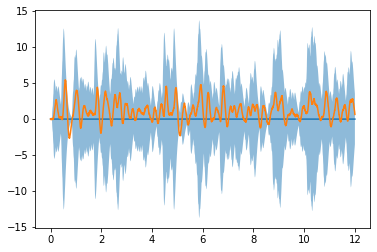

In [83]:
plt.plot(ytime, imeanpredict)
plt.plot(ytime, yvel[0])
plt.fill_between(ytime.flatten(), imeanpredictns2.flatten() - 2 * isigma_n,  
                  imeanpredictps2.flatten() + 2 * isigma_n, alpha = 0.5)

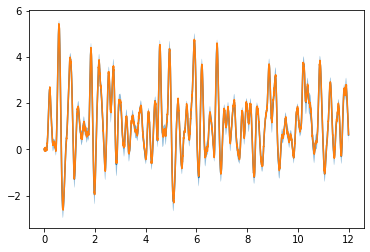

In [84]:
plt.plot(ytime, fmeanpredict)
plt.plot(ytime, yvel[0])
plt.fill_between(ytime.flatten(), fmeanpredictns2.flatten() - 2 * fsigma_n,  
                  fmeanpredictps2.flatten() + 2 * fsigma_n, alpha = 0.5)

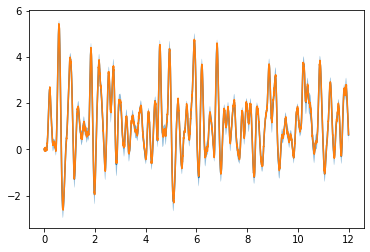

In [85]:
ytesttru = yvel[:, :3000]
ytimetru = ytime[:3000]
fmeanpredicttru = fmeanpredict[:3000]
fmeanpredictns2tru = fmeanpredictns2[:3000]
fmeanpredictps2tru = fmeanpredictps2[:3000]
plt.plot(ytimetru, fmeanpredicttru)
plt.plot(ytimetru, ytesttru[0])
plt.fill_between(ytimetru.flatten(), fmeanpredictns2tru.flatten() - 2 * fsigma_n,  
                  fmeanpredictps2tru.flatten() + 2 * fsigma_n, alpha = 0.5)